In [ ]:
# !apt-get install unrar

In [ ]:
# !unrar x /content/Data.rar

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import os
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import cv2
import os
import glob as gb
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import random


In [2]:
img_arrary = cv2.imread("/kaggle/input/emotion-detection/Data/train/angry/Training_3908.jpg")

In [3]:
img_arrary.shape

(48, 48, 3)

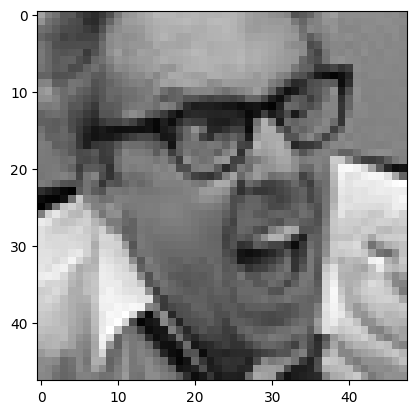

In [4]:
plt.imshow(img_arrary) # RGB ==> 3

## Check Pictures in Folders

In [24]:
test_path = "Data/test"
train_path='Data/train'
img_shape = 128
batch_size = 64

In [25]:
for folder in os.listdir(train_path):
    images=gb.glob(pathname=train_path + '/' +folder+'/*.jpg')
    print(f'for training data, we found {len(images)} in folder {folder}')

for training data, we found 3991 in folder angry
for training data, we found 436 in folder disgust
for training data, we found 4097 in folder fear
for training data, we found 7215 in folder happy
for training data, we found 4965 in folder neutral
for training data, we found 4830 in folder sad
for training data, we found 3171 in folder surprise


In [26]:
for folder in os.listdir(test_path):
    images=gb.glob(pathname=test_path + '/' +folder+'/*.jpg')
    print(f'for test data, we found {len(images)} in folder {folder}')

for test data, we found 958 in folder angry
for test data, we found 111 in folder disgust
for test data, we found 1024 in folder fear
for test data, we found 1774 in folder happy
for test data, we found 1233 in folder neutral
for test data, we found 1247 in folder sad
for test data, we found 831 in folder surprise


In [27]:
train_count = []
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
for folder in os.listdir(train_path):
    folder_path = train_path + '/' + folder
    print(folder, "folder contains\t\t", len(gb.glob(pathname=folder_path + '/*.jpg')), "image")
    train_count.append(len(os.listdir(folder_path)))

angry folder contains		 3991 image
disgust folder contains		 436 image
fear folder contains		 4097 image
happy folder contains		 7215 image
neutral folder contains		 4965 image
sad folder contains		 4830 image
surprise folder contains		 3171 image


In [28]:
train_count

[3991, 436, 4097, 7215, 4965, 4830, 3171]

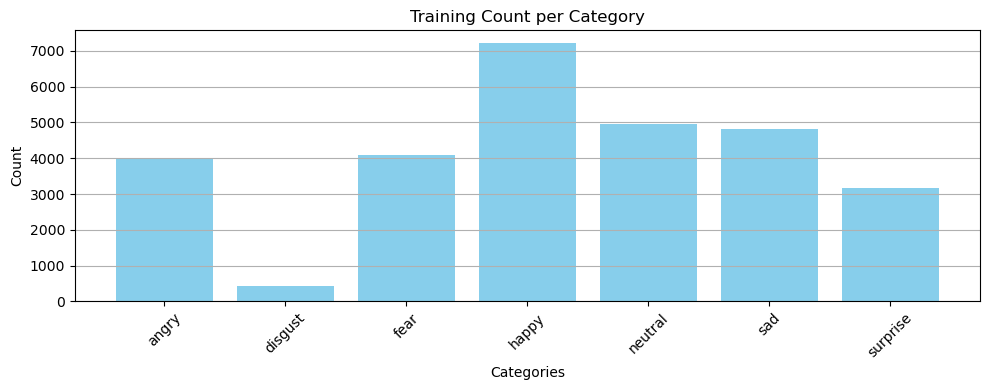

In [30]:
plt.figure(figsize=(10, 4))
plt.bar(emotions, train_count, color='skyblue')
plt.title('Training Count per Category')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate category labels for better visibility
plt.grid(axis='y')  # Add grid lines for better readability
plt.tight_layout()  # Adjust layout to fit labels

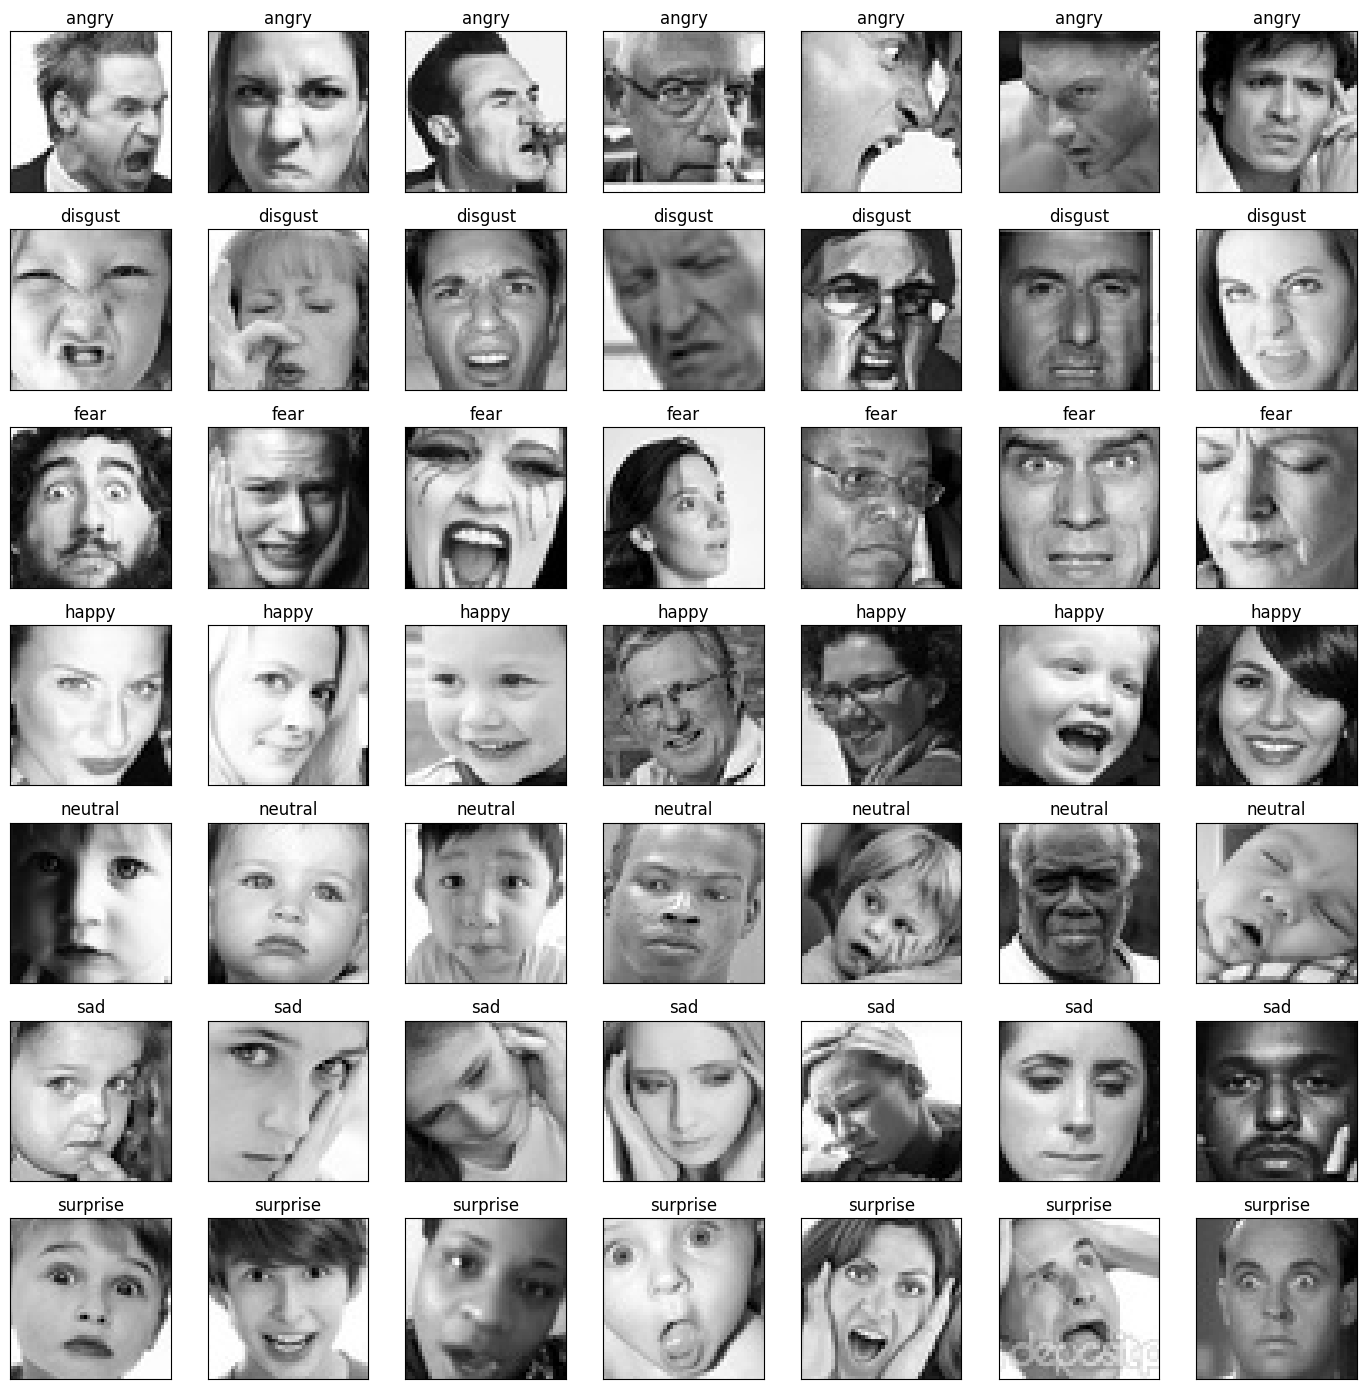

In [11]:
emotion_folders = sorted(os.listdir(train_path))

fig = plt.figure(1, (14, 14))

k = 0
for label in emotion_folders:
    # Get the full path of the folder for this label
    label_folder_path = os.path.join(train_path, label)

    # Get the list of images in this folder
    image_files = os.listdir(label_folder_path)

    # Shuffle the list of image files to pick random ones
    random.shuffle(image_files)

    # Loop through up to 7 random images (or fewer if there are less)
    for j in range(min(7, len(image_files))):
        # Construct the full image path
        image_path = os.path.join(label_folder_path, image_files[j])

        # Load the image
        img = Image.open(image_path).convert('L')  # Convert to grayscale

        # Convert image to numpy array and display it
        img_array = np.array(img)

        # Increment k for each subplot
        k += 1

        # Create a subplot in a 7x7 grid
        ax = plt.subplot(7, 7, k)
        ax.imshow(img_array, cmap='gray')  # Display image in grayscale

        # Remove axis ticks
        ax.set_xticks([])
        ax.set_yticks([])

        # Set the title to the emotion label (folder name)
        ax.set_title(label)

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()


# Preprocessing

In [12]:
# Define augmentation for the training data
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values
    zoom_range=0.3,          # Apply zoom augmentation
    horizontal_flip=True,    # Horizontal flipping
    rotation_range=30,       # Rotate images randomly
    shear_range=0.3,         # Apply shear transformations
    width_shift_range=0.2,   # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
)

# Data generator for test data (no augmentation, just normalization)
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
# Load the training data, excluding the validation split
train_set = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(img_shape, img_shape),
    batch_size=batch_size,
    shuffle=True,
    color_mode='rgb',  # Change to RGB
#     color_mode='grayscale'
    class_mode='categorical',
    subset='training'  # Use this subset for training
)

Found 28705 images belonging to 7 classes.


In [14]:
# Load the test data
test_set = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(img_shape, img_shape),
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle test data
    color_mode='rgb',  # Change to RGB
#     color_mode='grayscale'
    class_mode='categorical'
)


Found 7178 images belonging to 7 classes.


In [15]:
train_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [16]:
test_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [17]:
images, labels = next(train_set)
print("Input shape:", images.shape)

Input shape: (64, 128, 128, 3)


In [18]:
class_labels =['angry','disgust','fear', 'happy','neutral','sad','surprise']

## Modeling

In [19]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D ,GlobalMaxPooling2D

In [20]:
model = Sequential()

# Initial convolutional layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_shape, img_shape, 3), padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Further convolutional layers
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Additional convolutional layers
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Increase to 512 filters with padding=same
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Increase to 512 filters with padding=same
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))


# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# **New Section**

In [21]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [22]:
# Show model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 512)      │             

 Total params: 13,592,007 (51.85 MB)

 Trainable params: 13,588,039 (51.83 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [23]:
print(len(train_set), len(test_set))

449 113


In [24]:
history = model.fit(
    train_set,
    epochs=50,
    validation_data=test_set,
    batch_size=64,  # Remove this line if `train_set` is a dataset with pre-defined batch size
    verbose=1,
    callbacks=[early_stopping ]
)


Epoch 1/50


I0000 00:00:1730210044.363456     118 service.cc:145] XLA service 0x7f9dd800b840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730210044.363533     118 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730210044.363541     118 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1730210082.526547     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


449/449 ━━━━━━━━━━━━━━━━━━━━ 420s 829ms/step - accuracy: 0.1850 - loss: 2.4964 - val_accuracy: 0.2483 - val_loss: 1.7963
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 154s 338ms/step - accuracy: 0.2278 - loss: 1.9839 - val_accuracy: 0.2497 - val_loss: 1.8057
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 149s 327ms/step - accuracy: 0.2406 - loss: 1.8752 - val_accuracy: 0.2381 - val_loss: 1.8798
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 148s 324ms/step - accuracy: 0.2588 - loss: 1.8154 - val_accuracy: 0.2743 - val_loss: 1.7712
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 148s 324ms/step - accuracy: 0.2897 - loss: 1.7483 - val_accuracy: 0.2938 - val_loss: 1.7567
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 145s 318ms/step - accuracy: 0.3481 - loss: 1.6444 - val_accuracy: 0.4439 - val_loss: 1.4699
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 147s 322ms/step - accuracy: 0.3990 - loss: 1.5262 - val_accuracy: 0.4455 - val_loss: 1.4303
Epoch 8/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 148s 325ms/step - accuracy: 0.4509 - loss: 1.41

In [25]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_set, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - accuracy: 0.6590 - loss: 0.9323
Test Loss: 0.8713, Test Accuracy: 0.6814


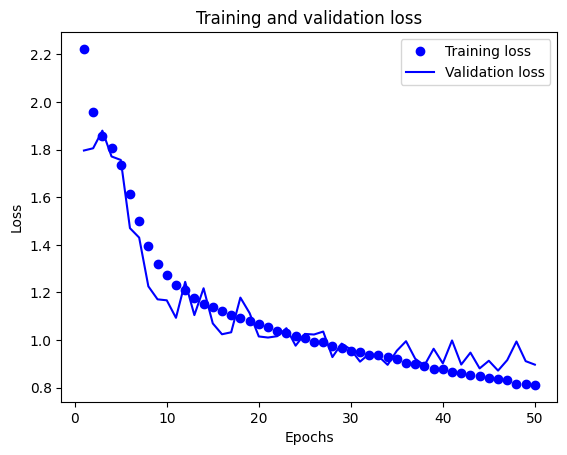

In [26]:
# Plot the train and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

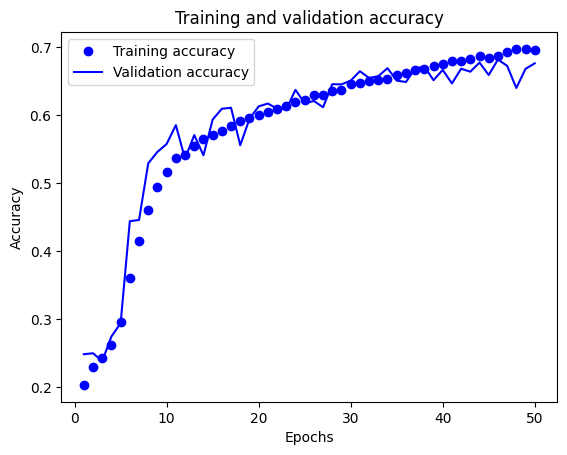

In [27]:
# Plot the train and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
model.save("/kaggle/working/Emotion_Detection_Model.keras")

In [30]:
model.save("/kaggle/working/Final_Emotion_Detection_Model.keras")

In [ ]:
# model.save("my_model.h5")

In [3]:
new_model = tf.keras.models.load_model("Final_Emotion_Detection_Model.keras")

In [4]:
frame = cv2.imread("Test Models/adel.jpg")

In [5]:
frame

array([[[246, 249, 253],
        [246, 249, 253],
        [246, 249, 253],
        ...,
        [240, 243, 247],
        [240, 243, 247],
        [240, 243, 247]],

       [[246, 249, 253],
        [246, 249, 253],
        [246, 249, 253],
        ...,
        [240, 243, 247],
        [240, 243, 247],
        [240, 243, 247]],

       [[246, 249, 253],
        [246, 249, 253],
        [246, 249, 253],
        ...,
        [240, 243, 247],
        [240, 243, 247],
        [240, 243, 247]],

       ...,

       [[ 14,   5,   8],
        [ 21,  12,  15],
        [ 43,  35,  36],
        ...,
        [ 10,  10,  24],
        [ 10,  10,  24],
        [ 10,  10,  24]],

       [[ 24,  15,  18],
        [ 29,  20,  23],
        [ 41,  33,  34],
        ...,
        [ 10,  10,  24],
        [ 10,  10,  24],
        [ 10,  10,  24]],

       [[ 29,  20,  23],
        [ 36,  27,  30],
        [ 43,  35,  36],
        ...,
        [ 10,  10,  24],
        [ 10,  10,  24],
        [ 10,  10,  24]]

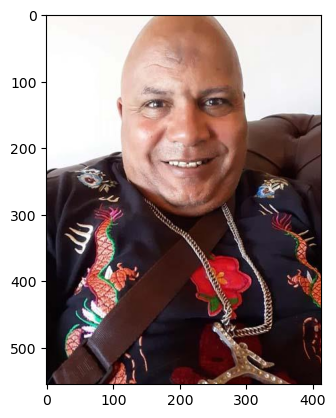

In [6]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

### ***Face Detection Algorithm***

In [7]:
Facecaseclass = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_default.xml')

In [12]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [13]:
gray.shape

(555, 413)

In [14]:
faces = Facecaseclass.detectMultiScale(gray, 1.3, 5)
for x , y , w , h in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]
    cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,255), 5)
    facess = Facecaseclass.detectMultiScale(roi_gray)
    if len(facess) == 0:
        print("Face not detected")
    else :
        for (ex, ey, ew, eh) in facess:
            face_roi = roi_color[ey: ey+eh, ex:ex + ew]

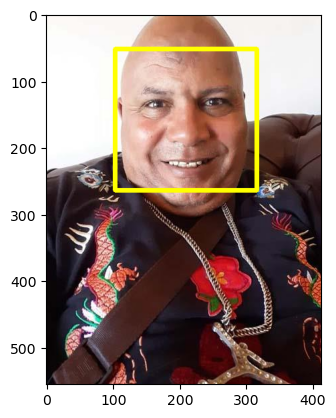

In [15]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [18]:
final_image = cv2.resize(face_roi, (128,128))
final_image = np.expand_dims(final_image, axis=0)
final_image = final_image/255.0

In [19]:
prediction = new_model.predict(final_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [20]:
prediction[0]

array([0.00816152, 0.00794132, 0.05152624, 0.89420134, 0.00746121,
       0.00751252, 0.02319592], dtype=float32)

In [21]:
np.argmax(prediction[0])

3

In [23]:
# {'angry': 0,
#  'disgust': 1,
#  'fear': 2,
#  'happy': 3,
#  'neutral': 4,
#  'sad': 5,
#  'surprise': 6}

In [9]:
import numpy as np

# Calculate the total number of parameters in the model
total_params = new_model.count_params()

# Estimate memory usage in bytes (4 bytes per parameter for float32)
memory_usage_bytes = total_params * 4

# Convert to megabytes
memory_usage_mb = memory_usage_bytes / (1024 ** 2)

print(f"Estimated memory usage: {memory_usage_mb:.2f} MB")


Estimated memory usage: 51.85 MB


In [10]:
new_model2 = new_model.astype(np.float32)

# Calculate the new memory usage in bytes
new_memory_usage_bytes = new_model2.memory_usage(deep=True).sum()

# Convert bytes to megabytes
new_memory_usage_mb = new_memory_usage_bytes / (1024 ** 2)

print(f"New memory usage of the DataFrame: {new_memory_usage_mb:.2f} MB")

AttributeError: 'Sequential' object has no attribute 'astype'